1. Load data

In [12]:
import os
import numpy as np
# set names to the paths because they're too long
data_path = 'C:\\Users\\Admin\\Downloads'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [13]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
  """
  This shuffle param is active when .gz is downloaded at:
  - 'http://yann.lecun.com/exdb/mnist/'
  - This function return random num_images in 60000 or 10000
  """
  # read data
  import gzip # to decompress gz (zip) file
  # open file training to read training data
  f_images = gzip.open(images_path,'r')
  # skip 16 first bytes because these are not data, only header infor
  f_images.read(16)
  # general: read num_images data samples if this parameter is set;
  # if not, read all (60000 training or 10000 test)
  real_num = num_images if not shuffle else (60000 if _is else 10000)
  # read all data to buf_images (28x28xreal_num)
  buf_images = f_images.read(image_size * image_size * real_num)
  # images
  images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
  images = images.reshape(real_num, image_size, image_size,)
  # Read labels
  f_labels = gzip.open(labels_path,'r')
  f_labels.read(8)
  labels = np.zeros((real_num)).astype(np.int64)
  # rearrange to correspond the images and labels
  for i in range(0, real_num):
    buf_labels = f_labels.read(1)
    labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
  # shuffle to get random images data
  if shuffle is True:
    rand_id = np.random.randint(real_num, size=num_images)
    images = images[rand_id, :]
    labels = labels[rand_id,]
  # change images data to type of vector 28x28 dimentional
  images = images.reshape(num_images, image_size * image_size)
  return images, labels

In [14]:
# chia train test
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000, shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11844\361972391.py:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



(60000, 784) (60000,)
(10000, 784) (10000,)


2. Check data

2.1. Visualize data

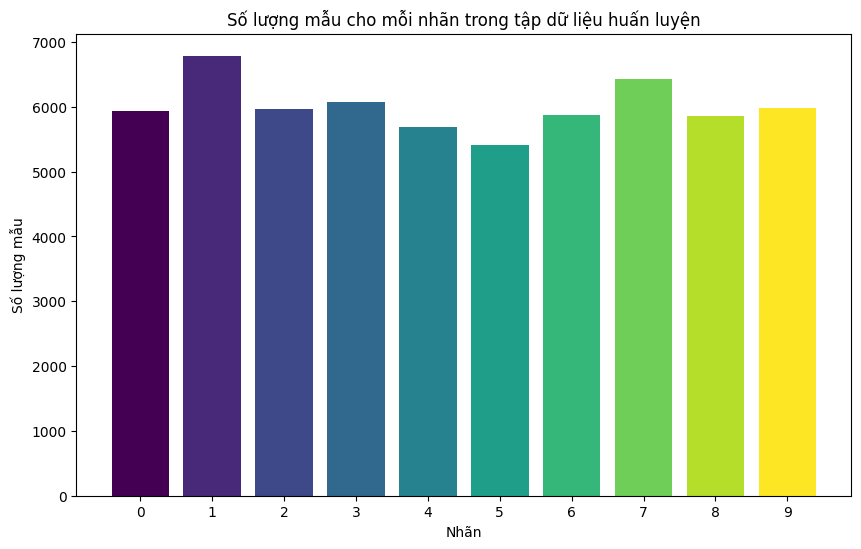

In [15]:
import matplotlib.pyplot as plt

label_counts = np.bincount(train_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(label_counts)))
labels = np.arange(len(label_counts))

plt.figure(figsize=(10, 6))
plt.bar(labels, label_counts, color=colors)
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu cho mỗi nhãn trong tập dữ liệu huấn luyện')

plt.xticks(labels)

plt.show()

2.2. Display and Test digit

In [16]:
def get_image(image):
    return image.reshape(28, 28)

In [17]:
def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y),
    (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

8 2
28


<Figure size 640x480 with 0 Axes>

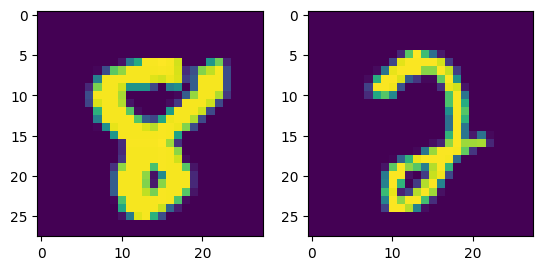

In [18]:
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])
train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()
print(len(train_image))
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

3. Reduce the dimensionality

3.1. Reduce the dimensionality of the data to 2 dimensions using the PCA method

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\collections.py:194: ComplexWarning:

Casting complex values to real discards the imaginary part



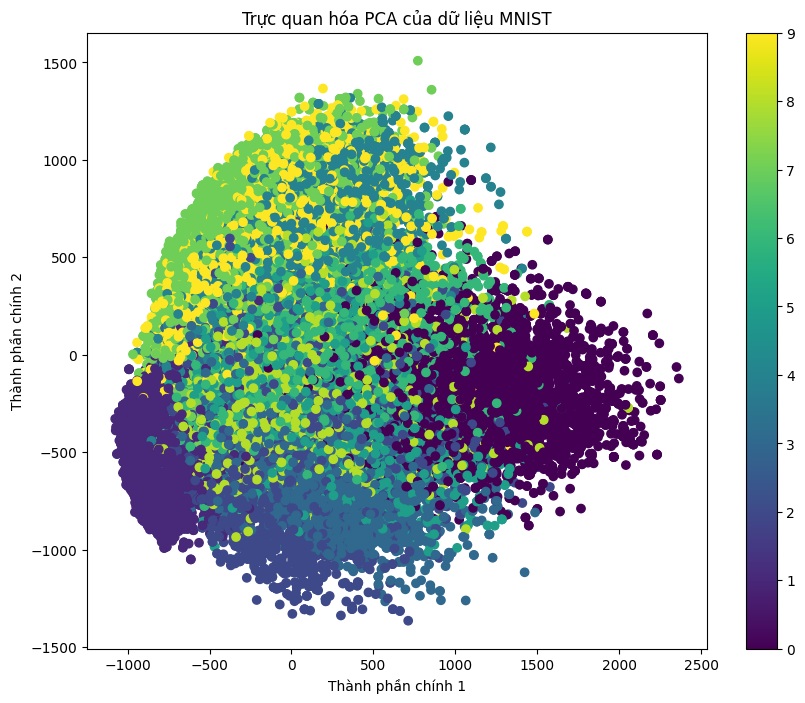

In [19]:
import matplotlib.pyplot as plt
# Tính giá trị trung bình của dữ liệu
mean_vec = np.mean(train_images, axis=0)

# Trừ đi giá trị trung bình để căn chỉnh dữ liệu về trung tâm
centered_data = train_images - mean_vec

# Tính ma trận hiệp phương sai của dữ liệu
cov_mat = np.cov(centered_data, rowvar=False)

# Thực hiện phân rã giá trị riêng
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

# Sắp xếp các giá trị riêng và vector riêng theo thứ tự giảm dần
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Chọn ra 2 vector riêng lớn nhất (mức độ "quan trọng") để giữ lại
k = 2
selected_eigenvectors = sorted_eigenvectors[:, :k]

# Chiếu dữ liệu đã căn chỉnh lên các vector riêng đã chọn
reduced_data = np.dot(centered_data, selected_eigenvectors)

# Hiển thị dữ liệu bằng scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis')
plt.colorbar()
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.title('Trực quan hóa PCA của dữ liệu MNIST')
plt.show()

3.2. Reduce the dimensionality of the data to 2 dimensions using the PCA method with scikit-learn library

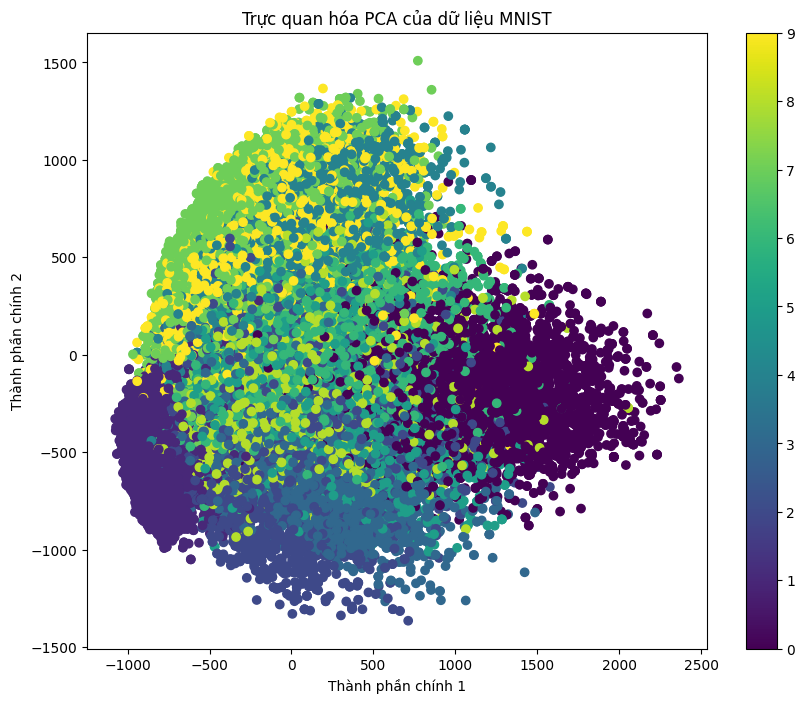

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# khởi tạo PCA
pca = PCA(n_components=2)

# huấn luyện mô hình
pca.fit(train_images)

# Giảm chiều dữ liệu
reduced_data = pca.transform(train_images)

# Hiển thị dữ liệu bằng scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis')
plt.colorbar()
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.title('Trực quan hóa PCA của dữ liệu MNIST')
plt.show()

3.3. Reduce the dimensionality of the data to 3 dimensions using the PCA method with scikit-learn library

[[  85.21256   790.3553   -287.01483 ]
 [-176.02397  -540.10065  -102.000595]
 [  64.56439  -499.70624   413.884   ]
 ...
 [-194.01788   756.0467   -407.47473 ]
 [ 816.5343    320.31897   237.09894 ]
 [-960.7184   -435.22717    98.41818 ]]


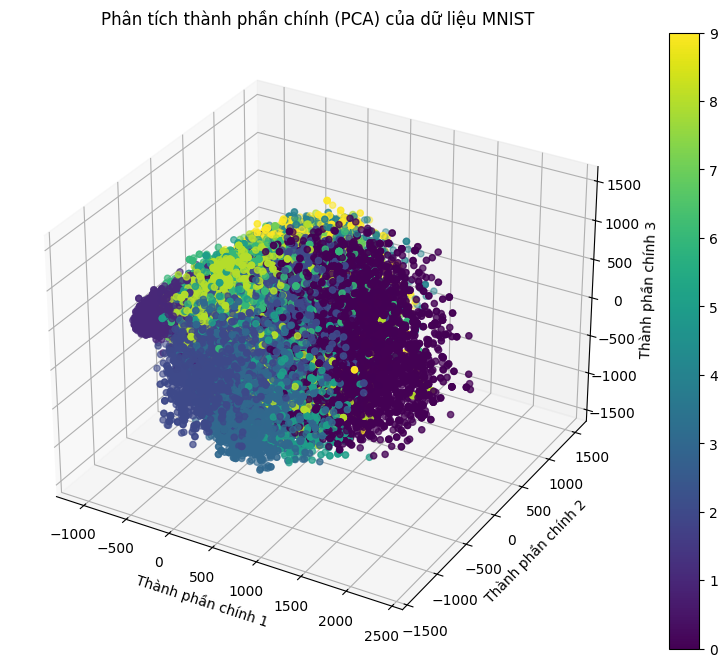

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Create an instance of PCA
pca = PCA(n_components=3)

# Fit PCA to the data
pca.fit(train_images)

# Transform the data to the lower-dimensional space
reduced_data = pca.transform(train_images)
print(reduced_data)
# Plot the data points in 3D
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=train_labels, cmap='viridis')

# Add colorbar
plt.colorbar(scatter)

ax.set_xlabel('Thành phần chính 1')
ax.set_ylabel('Thành phần chính 2')
ax.set_zlabel('Thành phần chính 3')
ax.set_title('Phân tích thành phần chính (PCA) của dữ liệu MNIST')

plt.show()